100%|██████████| 9.91M/9.91M [00:01<00:00, 5.47MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.36MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.61MB/s]


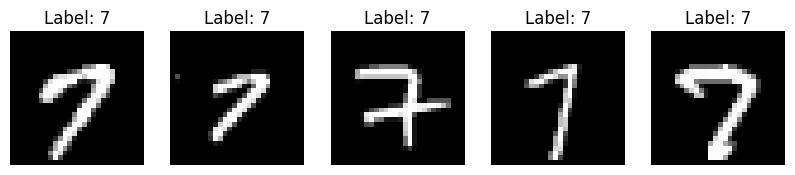

Epoch 1: Train Loss=0.1860, Train Acc=0.9436, Test Loss=0.0542, Test Acc=0.9822
Epoch 2: Train Loss=0.0520, Train Acc=0.9841, Test Loss=0.0426, Test Acc=0.9868
Epoch 3: Train Loss=0.0362, Train Acc=0.9887, Test Loss=0.0375, Test Acc=0.9866
Epoch 4: Train Loss=0.0279, Train Acc=0.9911, Test Loss=0.0387, Test Acc=0.9874
Epoch 5: Train Loss=0.0214, Train Acc=0.9932, Test Loss=0.0360, Test Acc=0.9882
Epoch 6: Train Loss=0.0166, Train Acc=0.9947, Test Loss=0.0330, Test Acc=0.9890
Epoch 7: Train Loss=0.0128, Train Acc=0.9958, Test Loss=0.0298, Test Acc=0.9903
Epoch 8: Train Loss=0.0108, Train Acc=0.9966, Test Loss=0.0329, Test Acc=0.9909
Epoch 9: Train Loss=0.0100, Train Acc=0.9965, Test Loss=0.0280, Test Acc=0.9913
Epoch 10: Train Loss=0.0071, Train Acc=0.9978, Test Loss=0.0318, Test Acc=0.9920


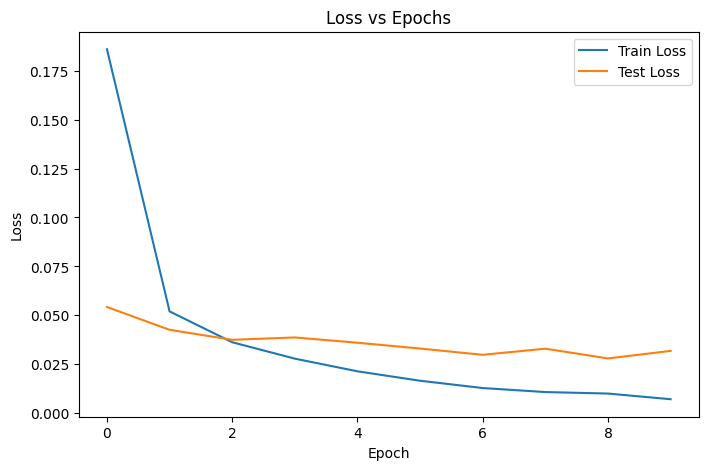

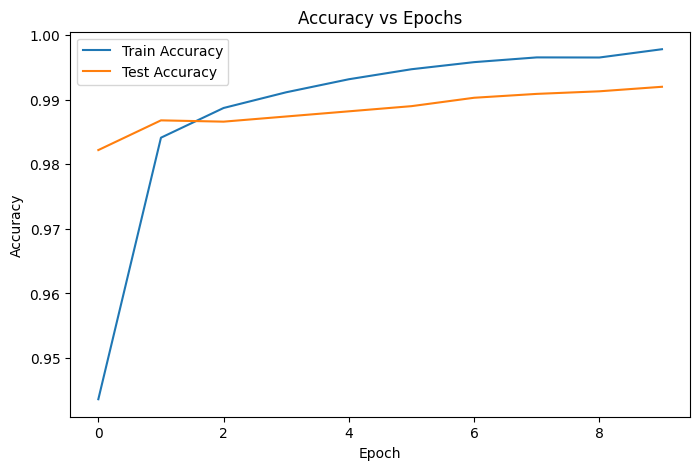

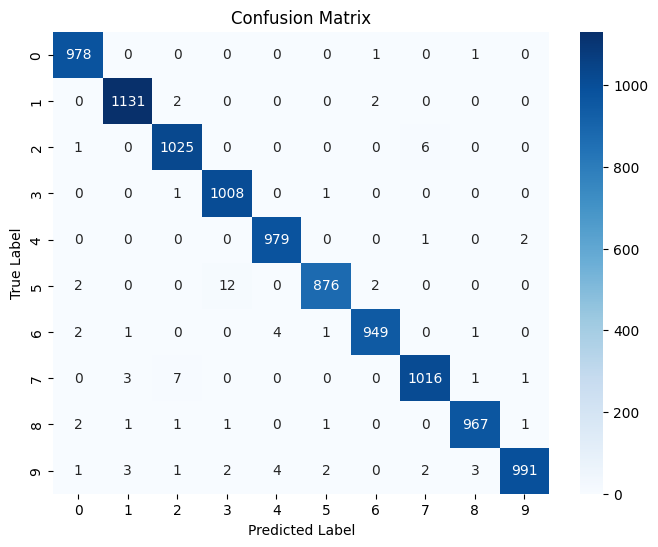

In [1]:
#Q1 : Convolutional Neural Network (CNN) — Classifying Handwritten Digits
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

#1.1: Load & Preprocess the Data
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor
    transforms.Normalize((0.0,), (1.0,))  # Normalize pixel values [0, 1]
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

#1.2: Visualize the Data (Show some digit '7')
def show_digit_examples(digit=7, num_examples=5):
    idxs = [i for i, (img, label) in enumerate(train_dataset) if label == digit][:num_examples]
    fig, axes = plt.subplots(1, num_examples, figsize=(10, 2))
    for ax, idx in zip(axes, idxs):
        img, label = train_dataset[idx]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.axis('off')
        ax.set_title(f"Label: {label}")
    plt.show()

show_digit_examples(7)

#1.3: Build the CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # output: 32x28x28
        self.pool1 = nn.MaxPool2d(2, 2)  # output: 32x14x14
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # output: 64x14x14
        self.pool2 = nn.MaxPool2d(2, 2)  # output: 64x7x7
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#1.4: Train the Model
num_epochs = 10
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate on test set
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= total
    test_acc = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch}: "
          f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Test Loss={test_loss:.4f}, Test Acc={test_acc:.4f}")

#1.5: Create Plots
#1.5.1 - Loss vs Epochs
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.show()

#1.5.2 - Accuracy vs Epochs
plt.figure(figsize=(8, 5))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy vs Epochs")
plt.show()

#1.5.3 - Final Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [2]:
#Q2 : Optional Extension: Improving Model Generalization with Data Augmentation
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

#2.2: Apply Data Augmentation to the Training Set
transform_train = transforms.Compose([
    transforms.RandomRotation(10),                   # Random rotation up to 10 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),# Random translation up to 10%
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# No augmentation for test set
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Define the same CNN architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = nn.MaxPool2d(2)(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        return nn.LogSoftmax(dim=1)(x)

# Create model, criterion, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#2.3: Train the Model with Augmented Data
def train(model, loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {total_loss / len(loader):.4f}')

#2.4: Compare with the Original Model
def test(model, loader):
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    test_loss /= len(loader)
    accuracy = 100. * correct / len(loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

# Run training and testing
train(model, train_loader, criterion, optimizer)  # Train with augmentation
test(model, test_loader)                          # Evaluate and compare


Epoch 1, Loss: 0.2641
Epoch 2, Loss: 0.0966
Epoch 3, Loss: 0.0734
Epoch 4, Loss: 0.0635
Epoch 5, Loss: 0.0547
Test Loss: 0.0254, Accuracy: 99.12%
